# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [468]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes, Process);

### Create a body

#### Create a cylinder

In [469]:
bcyl = let Npts = 100,  # total number of points on circle
            rad = 0.5,   # radius of circle
            xcent = [0.0,0.0],  # initial centroid of circle
            ang = 0.0    # initial angle of circle
   Bodies.Circle(Npts,rad,xcent,ang)
end

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.03141075907812899
     min spacing between points = 0.03141075907812807


#### Or create a plate

In [457]:
bplate = let Npts = 100,  # number of points on each flat side of plate
        len = 1.0,   # length of the plate
        thick = 0.023, # thickness
        λ = thick/len,  # a parameter that controls the ratio of spacing of points on plate
        xcent = [0.0,0.0], # initial centroid of the body
        ang = -π/4  # initial orientation of the body
        Bodies.Plate(Npts,len,thick,λ,xcent,ang)
end

Body: number of points = 364, reference point = (0.0,0.0), rotation matrix = [0.707107 0.707107; -0.707107 0.707107]
     max spacing between points = 0.01568667143291011
     min spacing between points = 0.0004387201713045025


### Create a domain with this body in it

In [470]:
dom = let xmin = [-1.0,-1.0], # minimum dimensions of domain
          xmax = [3.0,1.0]   # maximum dimensions of domain
        Systems.DualDomain(xmin,xmax)
end

# Add the body to the domain
dom = Systems.add_body(dom,bcyl)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.03141075907812899
     min spacing between points = 0.03141075907812807



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [471]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.03141075907812899
     min spacing between points = 0.03141075907812807

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [472]:
Re = 200
physparams = let U = [1.0,0.0]
    NavierStokes.set_freestream(U)
end
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)
tparams

Time step size 0.01

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [473]:
gops, ops = NavierStokes.set_operators_body!(dom,params);

Setting up LGF table
  0.394239 seconds (273.01 k allocations: 305.720 MiB, 17.19% gc time)
Setting up integrating factor table
  0.003342 seconds (2.18 k allocations: 1.916 MiB)
Setting up body-to-grid operator


Computing Eᵀ...100%|████████████████████████████████████| Time: 0:00:01


  3.075537 seconds (254.98 k allocations: 1021.608 MiB, 9.41% gc time)
Computing Schur complements and inverses


Computing G̃ᵀẼᵀ...100%|████████████████████████████████| Time: 0:00:01


  1.944728 seconds (123.17 k allocations: 166.857 MiB, 3.41% gc time)
  0.971086 seconds (12.18 k allocations: 128.918 MiB, 4.79% gc time)


### Create an initial solution structure

In [474]:
s = NavierStokes.BodySoln(dom)
h = [s]

1-element Array{Whirl2d.ConstrainedSoln{Array{Float64,2},Array{Float64,2}},1}:
 Solution: t = 0.0


### Advance the solution

In [475]:
@time for i = 1:200
    s = TimeMarching.ifherk!(s,tparams,ops)
    push!(h,s)
end
s

 21.732178 seconds (4.18 M allocations: 6.051 GiB, 9.20% gc time)


Solution: t = 2.0000000000000013


### Evaluate the fields in the solution history

In [476]:
@time f = NavierStokes.evaluateFields.(h,dom.grid,gops);
t = map(x -> x.t, f);
ω = map(x -> x.ω, f);
ψ = map(x -> x.ψ, f);
ux = map(x -> x.ux, f);
uy = map(x -> x.uy, f);

  1.586499 seconds (90.04 k allocations: 440.102 MiB, 28.63% gc time)


### Evaluate and plot the force history

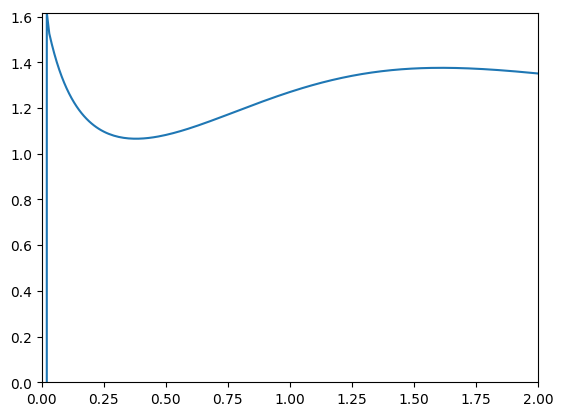

(0, 2.0000000000000013)

In [477]:
tforce, fx, fy = NavierStokes.force(h,dom.grid);
plot(tforce,2*fx)
ylim(0,maximum(2*fx))
xlim(0,tforce[end])

### Sample the solution at some point

In [12]:
spts = Process.SamplePoint(1.5,1.5)

Whirl2d.Process.SamplePoints([1.5], [1.5])

In [13]:
x = Grids.xfacex(dom.grid)
y = Grids.yfacex(dom.grid)
uxsamp = Process.sample(spts,ux,x,y)

1-element Array{Array{Float64,1},1}:
 [0.0, 0.0144011, 0.0147398, 0.0150096, 0.0152371, 0.0154388, 0.0156248, 0.0158013, 0.0159724, 0.0161409  …  0.0987671, 0.0992734, 0.0997759, 0.100274, 0.100769, 0.10126, 0.101746, 0.102228, 0.102706, 0.103179]

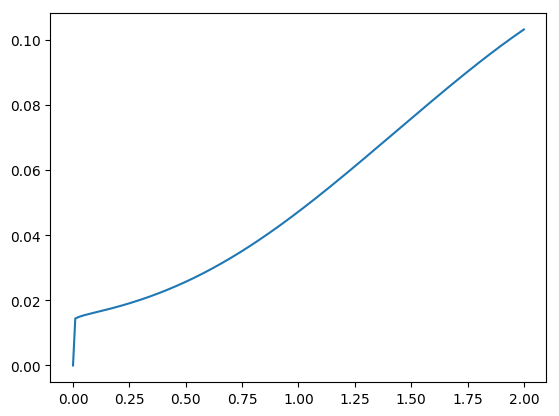

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12f6d2050>

In [14]:
plot(t,uxsamp[1])

### Plot the fields

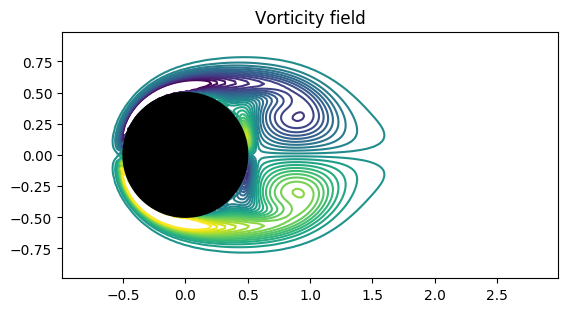

PyObject <matplotlib.text.Text object at 0x152d249d0>

In [466]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,transpose(ω[end]),linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Vorticity field")

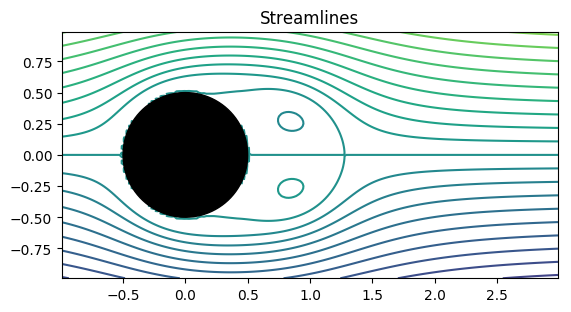

PyObject <matplotlib.text.Text object at 0x13027c250>

In [16]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)
contour(x,y,y.+transpose(ψ[end]),linspace(-1.5,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Streamlines")

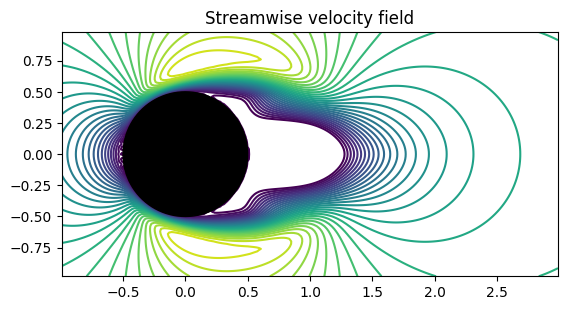

PyObject <matplotlib.text.Text object at 0x1305d9c10>

In [17]:
contour(Grids.xfacex(dom.grid),Grids.yfacex(dom.grid),transpose(ux[end]).+1,linspace(0,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Streamwise velocity field")

### Evaluate the surface tractions

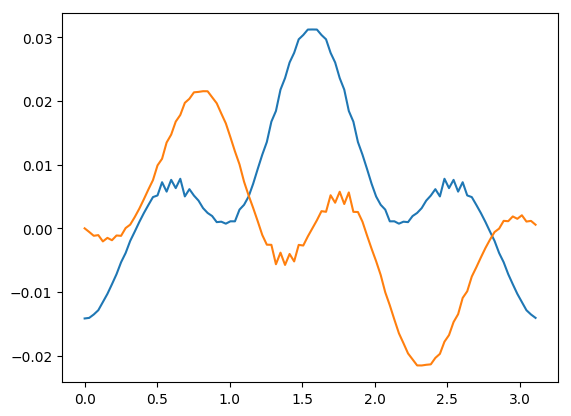

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1595d6490>
 PyObject <matplotlib.lines.Line2D object at 0x1595d6210>

In [454]:
norms = [map(x -> x[1], Bodies.normal(bcyl)) map(x -> x[2], Bodies.normal(bcyl))]
tract = h(0.5).f*dom.grid.Δx^2
ds = Bodies.ds(bcyl);
s = cumsum([0; 0.5*(ds[1:bcyl.N-1]+ds[2:bcyl.N])]);
plot(s,tract)

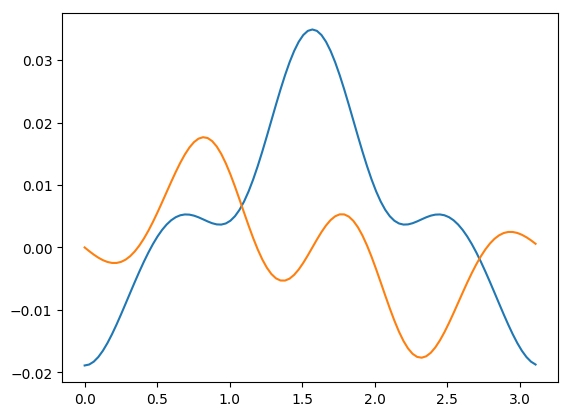

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2086d6b50>
 PyObject <matplotlib.lines.Line2D object at 0x2086d6d50>

In [478]:
norms = [map(x -> x[1], Bodies.normal(bcyl)) map(x -> x[2], Bodies.normal(bcyl))]
tract = h(0.5).f*dom.grid.Δx^2
ds = Bodies.ds(bcyl);
s = cumsum([0; 0.5*(ds[1:bcyl.N-1]+ds[2:bcyl.N])]);
plot(s,tract)